# 일봉 차트

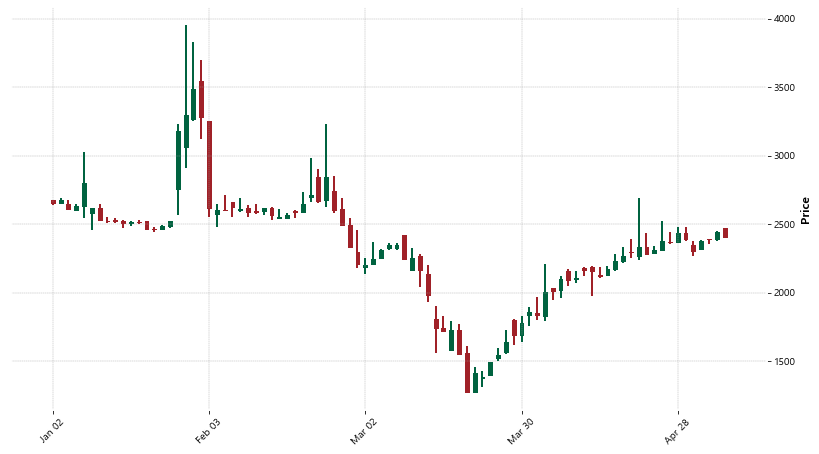

In [22]:
from mod1 import *
import matplotlib.gridspec as gridspec
import mplfinance as mpf


df = select_stock('hrs', '2020-01-01')

ohlc = df[['Date','Open', 'High', 'Low', 'Close','Volume']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc = ohlc.set_index('Date')
ohlc.index.name = 'Date'

mpf.plot(ohlc,figratio=(15,8),figscale=1.0,type='candle',style='charles')

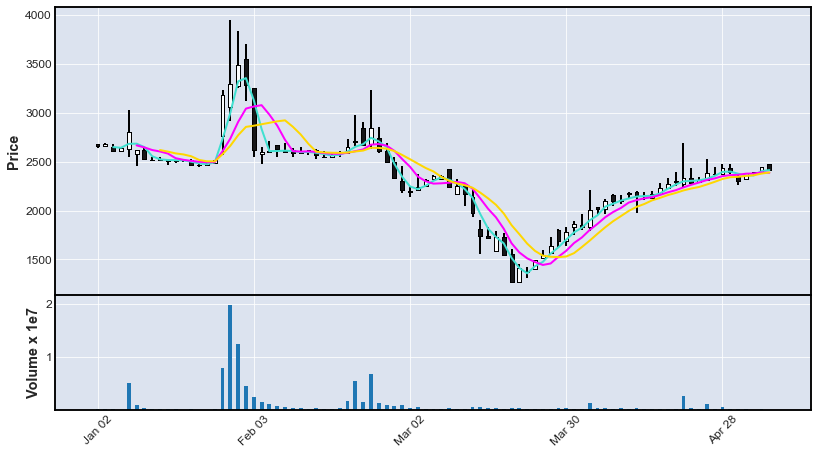

In [17]:
from mod1 import *
import matplotlib.gridspec as gridspec
import mplfinance as mpf


df = select_stock('hrs', '2020-01-01')

ohlc = df[['Date','Open', 'High', 'Low', 'Close','Volume']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc = ohlc.set_index('Date')
ohlc.index.name = 'Date'

mpf.plot(ohlc,figratio=(15,8),type='candle',mav=(3,6,9),volume=True)  ### 3,6,9일 이동평균선 그리고 거래량


In [16]:
from mod1 import *
import plotly.offline as offline
import plotly.graph_objs as go

df = select_stock('hrs', '2020-01-01')
olhc = df[['Date','Open','High','Low','Close']]

offline.init_notebook_mode(connected = True)

trace = go.Candlestick(x=olhc.Date, open=olhc.Open, high=olhc.High, low=olhc.Low, close = olhc.Close)
data =[trace]

layout=go.Layout(title='hrs')
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig,filename='candlestick')

# Technical-Analysis without Talib

In [ ]:
### https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code


import numpy  
import pandas as pd  
import math as m


#Moving Average  
def MA(df, n):  
    MA = pd.Series(pd.rolling_mean(df['Close'], n), name = 'MA_' + str(n))  
    df = df.join(MA)  
    return df

#Exponential Moving Average  
def EMA(df, n):  
    EMA = pd.Series(pd.ewma(df['Close'], span = n, min_periods = n - 1), name = 'EMA_' + str(n))  
    df = df.join(EMA)  
    return df

#Momentum  
def MOM(df, n):  
    M = pd.Series(df['Close'].diff(n), name = 'Momentum_' + str(n))  
    df = df.join(M)  
    return df

#Rate of Change  
def ROC(df, n):  
    M = df['Close'].diff(n - 1)  
    N = df['Close'].shift(n - 1)  
    ROC = pd.Series(M / N, name = 'ROC_' + str(n))  
    df = df.join(ROC)  
    return df

#Average True Range  
def ATR(df,n): #df is the DataFrame, n is the period 7,14 ,etc
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.at[n-1,'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas version- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
    return df

#Bollinger Bands  
def BBANDS(df, n):  
    MA = pd.Series(pd.rolling_mean(df['Close'], n))  
    MSD = pd.Series(pd.rolling_std(df['Close'], n))  
    b1 = 4 * MSD / MA  
    B1 = pd.Series(b1, name = 'BollingerB_' + str(n))  
    df = df.join(B1)  
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)  
    B2 = pd.Series(b2, name = 'Bollinger%b_' + str(n))  
    df = df.join(B2)  
    return df

#Pivot Points, Supports and Resistances  
def PPSR(df):  
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)  
    R1 = pd.Series(2 * PP - df['Low'])  
    S1 = pd.Series(2 * PP - df['High'])  
    R2 = pd.Series(PP + df['High'] - df['Low'])  
    S2 = pd.Series(PP - df['High'] + df['Low'])  
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))  
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))  
    psr = {'PP':PP, 'R1':R1, 'S1':S1, 'R2':R2, 'S2':S2, 'R3':R3, 'S3':S3}  
    PSR = pd.DataFrame(psr)  
    df = df.join(PSR)  
    return df

#Stochastic oscillator %K  
def STOK(df):  
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name = 'SO%k')  
    df = df.join(SOk)  
    return df

# Stochastic Oscillator, EMA smoothing, nS = slowing (1 if no slowing)  
def STO(df,  nK, nD, nS=1):  
    SOk = pd.Series((df['Close'] - df['Low'].rolling(nK).min()) / (df['High'].rolling(nK).max() - df['Low'].rolling(nK).min()), name = 'SO%k'+str(nK))  
    SOd = pd.Series(SOk.ewm(ignore_na=False, span=nD, min_periods=nD-1, adjust=True).mean(), name = 'SO%d'+str(nD))  
    SOk = SOk.ewm(ignore_na=False, span=nS, min_periods=nS-1, adjust=True).mean()  
    SOd = SOd.ewm(ignore_na=False, span=nS, min_periods=nS-1, adjust=True).mean()  
    df = df.join(SOk)  
    df = df.join(SOd)  
    return df  
# Stochastic Oscillator, SMA smoothing, nS = slowing (1 if no slowing)  
def STO(df, nK, nD,  nS=1):  
    SOk = pd.Series((df['Close'] - df['Low'].rolling(nK).min()) / (df['High'].rolling(nK).max() - df['Low'].rolling(nK).min()), name = 'SO%k'+str(nK))  
    SOd = pd.Series(SOk.rolling(window=nD, center=False).mean(), name = 'SO%d'+str(nD))  
    SOk = SOk.rolling(window=nS, center=False).mean()  
    SOd = SOd.rolling(window=nS, center=False).mean()  
    df = df.join(SOk)  
    df = df.join(SOd)  
    return df  
#Trix  
def TRIX(df, n):  
    EX1 = pd.ewma(df['Close'], span = n, min_periods = n - 1)  
    EX2 = pd.ewma(EX1, span = n, min_periods = n - 1)  
    EX3 = pd.ewma(EX2, span = n, min_periods = n - 1)  
    i = 0  
    ROC_l = [0]  
    while i + 1 <= df.index[-1]:  
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]  
        ROC_l.append(ROC)  
        i = i + 1  
    Trix = pd.Series(ROC_l, name = 'Trix_' + str(n))  
    df = df.join(Trix)  
    return df

#Average Directional Movement Index  
def ADX(df, n, n_ADX):  
    i = 0  
    UpI = []  
    DoI = []  
    while i + 1 <= df.index[-1]:  
        UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(pd.ewma(TR_s, span = n, min_periods = n))  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(pd.ewma(UpI, span = n, min_periods = n - 1) / ATR)  
    NegDI = pd.Series(pd.ewma(DoI, span = n, min_periods = n - 1) / ATR)  
    ADX = pd.Series(pd.ewma(abs(PosDI - NegDI) / (PosDI + NegDI), span = n_ADX, min_periods = n_ADX - 1), name = 'ADX_' + str(n) + '_' + str(n_ADX))  
    df = df.join(ADX)  
    return df

#MACD, MACD Signal and MACD difference  
def MACD(df, n_fast, n_slow):  
    EMAfast = pd.Series(pd.ewma(df['Close'], span = n_fast, min_periods = n_slow - 1))  
    EMAslow = pd.Series(pd.ewma(df['Close'], span = n_slow, min_periods = n_slow - 1))  
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))  
    MACDsign = pd.Series(pd.ewma(MACD, span = 9, min_periods = 8), name = 'MACDsign_' + str(n_fast) + '_' + str(n_slow))  
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))  
    df = df.join(MACD)  
    df = df.join(MACDsign)  
    df = df.join(MACDdiff)  
    return df

#Mass Index  
def MassI(df):  
    Range = df['High'] - df['Low']  
    EX1 = pd.ewma(Range, span = 9, min_periods = 8)  
    EX2 = pd.ewma(EX1, span = 9, min_periods = 8)  
    Mass = EX1 / EX2  
    MassI = pd.Series(pd.rolling_sum(Mass, 25), name = 'Mass Index')  
    df = df.join(MassI)  
    return df

#Vortex Indicator: http://www.vortexindicator.com/VFX_VORTEX.PDF  
def Vortex(df, n):  
    i = 0  
    TR = [0]  
    while i < df.index[-1]:  
        Range = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR.append(Range)  
        i = i + 1  
    i = 0  
    VM = [0]  
    while i < df.index[-1]:  
        Range = abs(df.get_value(i + 1, 'High') - df.get_value(i, 'Low')) - abs(df.get_value(i + 1, 'Low') - df.get_value(i, 'High'))  
        VM.append(Range)  
        i = i + 1  
    VI = pd.Series(pd.rolling_sum(pd.Series(VM), n) / pd.rolling_sum(pd.Series(TR), n), name = 'Vortex_' + str(n))  
    df = df.join(VI)  
    return df





#KST Oscillator  
def KST(df, r1, r2, r3, r4, n1, n2, n3, n4):  
    M = df['Close'].diff(r1 - 1)  
    N = df['Close'].shift(r1 - 1)  
    ROC1 = M / N  
    M = df['Close'].diff(r2 - 1)  
    N = df['Close'].shift(r2 - 1)  
    ROC2 = M / N  
    M = df['Close'].diff(r3 - 1)  
    N = df['Close'].shift(r3 - 1)  
    ROC3 = M / N  
    M = df['Close'].diff(r4 - 1)  
    N = df['Close'].shift(r4 - 1)  
    ROC4 = M / N  
    KST = pd.Series(pd.rolling_sum(ROC1, n1) + pd.rolling_sum(ROC2, n2) * 2 + pd.rolling_sum(ROC3, n3) * 3 + pd.rolling_sum(ROC4, n4) * 4, name = 'KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(n2) + '_' + str(n3) + '_' + str(n4))  
    df = df.join(KST)  
    return df

#Relative Strength Index  
def RSI(df, n):  
    i = 0  
    UpI = [0]  
    DoI = [0]  
    while i + 1 <= df.index[-1]:  
        UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(pd.ewma(UpI, span = n, min_periods = n - 1))  
    NegDI = pd.Series(pd.ewma(DoI, span = n, min_periods = n - 1))  
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))  
    df = df.join(RSI)  
    return df

#True Strength Index  
def TSI(df, r, s):  
    M = pd.Series(df['Close'].diff(1))  
    aM = abs(M)  
    EMA1 = pd.Series(pd.ewma(M, span = r, min_periods = r - 1))  
    aEMA1 = pd.Series(pd.ewma(aM, span = r, min_periods = r - 1))  
    EMA2 = pd.Series(pd.ewma(EMA1, span = s, min_periods = s - 1))  
    aEMA2 = pd.Series(pd.ewma(aEMA1, span = s, min_periods = s - 1))  
    TSI = pd.Series(EMA2 / aEMA2, name = 'TSI_' + str(r) + '_' + str(s))  
    df = df.join(TSI)  
    return df

#Accumulation/Distribution  
def ACCDIST(df, n):  
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']  
    M = ad.diff(n - 1)  
    N = ad.shift(n - 1)  
    ROC = M / N  
    AD = pd.Series(ROC, name = 'Acc/Dist_ROC_' + str(n))  
    df = df.join(AD)  
    return df

#Chaikin Oscillator  
def Chaikin(df):  
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']  
    Chaikin = pd.Series(pd.ewma(ad, span = 3, min_periods = 2) - pd.ewma(ad, span = 10, min_periods = 9), name = 'Chaikin')  
    df = df.join(Chaikin)  
    return df

#Money Flow Index and Ratio  
def MFI(df, n):  
    PP = (df['High'] + df['Low'] + df['Close']) / 3  
    i = 0  
    PosMF = [0]  
    while i < df.index[-1]:  
        if PP[i + 1] > PP[i]:  
            PosMF.append(PP[i + 1] * df.get_value(i + 1, 'Volume'))  
        else:  
            PosMF.append(0)  
        i = i + 1  
    PosMF = pd.Series(PosMF)  
    TotMF = PP * df['Volume']  
    MFR = pd.Series(PosMF / TotMF)  
    MFI = pd.Series(pd.rolling_mean(MFR, n), name = 'MFI_' + str(n))  
    df = df.join(MFI)  
    return df

#On-balance Volume  
def OBV(df, n):  
    i = 0  
    OBV = [0]  
    while i < df.index[-1]:  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') > 0:  
            OBV.append(df.get_value(i + 1, 'Volume'))  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') == 0:  
            OBV.append(0)  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') < 0:  
            OBV.append(-df.get_value(i + 1, 'Volume'))  
        i = i + 1  
    OBV = pd.Series(OBV)  
    OBV_ma = pd.Series(pd.rolling_mean(OBV, n), name = 'OBV_' + str(n))  
    df = df.join(OBV_ma)  
    return df

#Force Index  
def FORCE(df, n):  
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name = 'Force_' + str(n))  
    df = df.join(F)  
    return df

#Ease of Movement  
def EOM(df, n):  
    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])  
    Eom_ma = pd.Series(pd.rolling_mean(EoM, n), name = 'EoM_' + str(n))  
    df = df.join(Eom_ma)  
    return df

#Commodity Channel Index  
def CCI(df, n):  
    PP = (df['High'] + df['Low'] + df['Close']) / 3  
    CCI = pd.Series((PP - pd.rolling_mean(PP, n)) / pd.rolling_std(PP, n), name = 'CCI_' + str(n))  
    df = df.join(CCI)  
    return df

#Coppock Curve  
def COPP(df, n):  
    M = df['Close'].diff(int(n * 11 / 10) - 1)  
    N = df['Close'].shift(int(n * 11 / 10) - 1)  
    ROC1 = M / N  
    M = df['Close'].diff(int(n * 14 / 10) - 1)  
    N = df['Close'].shift(int(n * 14 / 10) - 1)  
    ROC2 = M / N  
    Copp = pd.Series(pd.ewma(ROC1 + ROC2, span = n, min_periods = n), name = 'Copp_' + str(n))  
    df = df.join(Copp)  
    return df

#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(pd.rolling_mean((df['High'] + df['Low'] + df['Close']) / 3, n), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(pd.rolling_mean((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3, n), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(pd.rolling_mean((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3, n), name = 'KelChD_' + str(n))  
    df = df.join(KelChM)  
    df = df.join(KelChU)  
    df = df.join(KelChD)  
    return df

#Ultimate Oscillator  
def ULTOSC(df):  
    i = 0  
    TR_l = [0]  
    BP_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR_l.append(TR)  
        BP = df.get_value(i + 1, 'Close') - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        BP_l.append(BP)  
        i = i + 1  
    UltO = pd.Series((4 * pd.rolling_sum(pd.Series(BP_l), 7) / pd.rolling_sum(pd.Series(TR_l), 7)) + (2 * pd.rolling_sum(pd.Series(BP_l), 14) / pd.rolling_sum(pd.Series(TR_l), 14)) + (pd.rolling_sum(pd.Series(BP_l), 28) / pd.rolling_sum(pd.Series(TR_l), 28)), name = 'Ultimate_Osc')  
    df = df.join(UltO)  
    return df

#Donchian Channel  
def DONCH(df, n):  
    i = 0  
    DC_l = []  
    while i < n - 1:  
        DC_l.append(0)  
        i = i + 1  
    i = 0  
    while i + n - 1 < df.index[-1]:  
        DC = max(df['High'].ix[i:i + n - 1]) - min(df['Low'].ix[i:i + n - 1])  
        DC_l.append(DC)  
        i = i + 1  
    DonCh = pd.Series(DC_l, name = 'Donchian_' + str(n))  
    DonCh = DonCh.shift(n - 1)  
    df = df.join(DonCh)  
    return df
`
#Standard Deviation  
def STDDEV(df, n):  
    df = df.join(pd.Series(pd.rolling_std(df['Close'], n), name = 'STD_' + str(n)))  
    return df  

In [ ]:
"""
Indicators as shown by Peter Bakker at:
https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code
"""

"""
25-Mar-2018: Fixed syntax to support the newest version of Pandas. Warnings should no longer appear.
             Fixed some bugs regarding min_periods and NaN.
			 If you find any bugs, please report to github.com/palmbook
"""

# Import Built-Ins
import logging

# Import Third-Party
import pandas as pd
import numpy as np

# Import Homebrew

# Init Logging Facilities
log = logging.getLogger(__name__)


def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


def average_true_range(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df = df.join(ATR)
    return df


def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df


def ppsr(df):
    """Calculate Pivot Points, Supports and Resistances for given data
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)
    R1 = pd.Series(2 * PP - df['Low'])
    S1 = pd.Series(2 * PP - df['High'])
    R2 = pd.Series(PP + df['High'] - df['Low'])
    S2 = pd.Series(PP - df['High'] + df['Low'])
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))
    psr = {'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2, 'R3': R3, 'S3': S3}
    PSR = pd.DataFrame(psr)
    df = df.join(PSR)
    return df


def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df


def trix(df, n):
    """Calculate TRIX for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    df = df.join(Trix)
    return df


def average_directional_movement_index(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df = df.join(ADX)
    return df


def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def mass_index(df):
    """Calculate the Mass Index for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    Range = df['High'] - df['Low']
    EX1 = Range.ewm(span=9, min_periods=9).mean()
    EX2 = EX1.ewm(span=9, min_periods=9).mean()
    Mass = EX1 / EX2
    MassI = pd.Series(Mass.rolling(25).sum(), name='Mass Index')
    df = df.join(MassI)
    return df


def vortex_indicator(df, n):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    return df


def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
    """Calculate KST Oscillator for given data.
    
    :param df: pandas.DataFrame
    :param r1: 
    :param r2: 
    :param r3: 
    :param r4: 
    :param n1: 
    :param n2: 
    :param n3: 
    :param n4: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(r1 - 1)
    N = df['Close'].shift(r1 - 1)
    ROC1 = M / N
    M = df['Close'].diff(r2 - 1)
    N = df['Close'].shift(r2 - 1)
    ROC2 = M / N
    M = df['Close'].diff(r3 - 1)
    N = df['Close'].shift(r3 - 1)
    ROC3 = M / N
    M = df['Close'].diff(r4 - 1)
    N = df['Close'].shift(r4 - 1)
    ROC4 = M / N
    KST = pd.Series(
        ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
        name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
            n2) + '_' + str(n3) + '_' + str(n4))
    df = df.join(KST)
    return df


def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df


def true_strength_index(df, r, s):
    """Calculate True Strength Index (TSI) for given data.
    
    :param df: pandas.DataFrame
    :param r: 
    :param s: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(1))
    aM = abs(M)
    EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
    aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
    EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
    aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
    TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
    df = df.join(TSI)
    return df


def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df


def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    Chaikin = pd.Series(ad.ewm(span=3, min_periods=3).mean() - ad.ewm(span=10, min_periods=10).mean(), name='Chaikin')
    df = df.join(Chaikin)
    return df


def money_flow_index(df, n):
    """Calculate Money Flow Index and Ratio for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.loc[i + 1, 'Volume'])
        else:
            PosMF.append(0)
        i = i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
    df = df.join(MFI)
    return df


def on_balance_volume(df, n):
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df = df.join(OBV_ma)
    return df


def force_index(df, n):
    """Calculate Force Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
    df = df.join(F)
    return df


def ease_of_movement(df, n):
    """Calculate Ease of Movement for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])
    Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
    df = df.join(Eom_ma)
    return df


def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df


def coppock_curve(df, n):
    """Calculate Coppock Curve for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(int(n * 11 / 10) - 1)
    N = df['Close'].shift(int(n * 11 / 10) - 1)
    ROC1 = M / N
    M = df['Close'].diff(int(n * 14 / 10) - 1)
    N = df['Close'].shift(int(n * 14 / 10) - 1)
    ROC2 = M / N
    Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
    df = df.join(Copp)
    return df


def keltner_channel(df, n):
    """Calculate Keltner Channel for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChM_' + str(n))
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChU_' + str(n))
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChD_' + str(n))
    df = df.join(KelChM)
    df = df.join(KelChU)
    df = df.join(KelChD)
    return df


def ultimate_oscillator(df):
    """Calculate Ultimate Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    BP_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        BP = df.loc[i + 1, 'Close'] - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        BP_l.append(BP)
        i = i + 1
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(7).sum() / pd.Series(TR_l).rolling(7).sum()) + (
                2 * pd.Series(BP_l).rolling(14).sum() / pd.Series(TR_l).rolling(14).sum()) + (
                                 pd.Series(BP_l).rolling(28).sum() / pd.Series(TR_l).rolling(28).sum()),
                     name='Ultimate_Osc')
    df = df.join(UltO)
    return df


def donchian_channel(df, n):
    """Calculate donchian channel of given pandas data frame.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    dc_l = []
    while i < n - 1:
        dc_l.append(0)
        i += 1

    i = 0
    while i + n - 1 < df.index[-1]:
        dc = max(df['High'].ix[i:i + n - 1]) - min(df['Low'].ix[i:i + n - 1])
        dc_l.append(dc)
        i += 1

    donchian_chan = pd.Series(dc_l, name='Donchian_' + str(n))
    donchian_chan = donchian_chan.shift(n - 1)
    return df.join(donchian_chan)


def standard_deviation(df, n):
    """Calculate Standard Deviation for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    df = df.join(pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
    return df